In [1]:
import os

from models.vae import DenseVariationalAutoencoder
from models.utils.loaders import load_mnist
import pandas as pd
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
from matplotlib import pyplot as plt
import tensorflow as tf

disable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

N_DENSE = 2
L=16
TRAINING_FRACTION = 0.8
NON_LINEAR_ACTIVATION_BOOL=True

In [2]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"

In [3]:
# run params
SECTION = 'vae'
RUN_ID = '0003'
#DATA_NAME = 'digits'
DATA_NAME = 'ising'
RUN_FOLDER = '{}/run/{}/'.format(os.getcwd(), SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


In [4]:
df_bins = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/bins_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), sep="\t")
df_conf = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/spinConfigs_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), delimiter=r"\s+", header=None)

In [5]:
df_bins = df_bins[df_bins[' T '] != ' T ']

In [6]:
df_bins = df_bins.astype(
    {
        " T ": int,
        " binNum": int,
    }
)

## Get the temp and magnatization into the configuration dataframe

In [7]:
df_conf["T"] = df_bins[" T "]

In [8]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [9]:
df_conf["M"] = mean_col

In [10]:
filterned_confs = df_conf
#filterned_confs = df_conf[(df_conf["T"] < 1.5) | (df_conf["T"] > 4.5)]
#filterned_confs = df_conf[df_conf["T"] > 0.5]

In [11]:
filterned_confs.head()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,T,M
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0


We need the data in the format: `(x_train, y_train), (x_test, y_test)`

In [12]:
train_with_meta_info = filterned_confs.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = filterned_confs.drop(index=train_with_meta_info.index)

In [13]:
train = train_with_meta_info.drop(["T","M"], axis=1)
test = test_with_meta_info.drop(["T","M"], axis=1)

## Shape our data

In [14]:
train.to_numpy().shape

(4000, 256)

In [15]:
x = train.to_numpy().reshape(-1,L*L)
x_test = test.to_numpy().reshape(-1,L*L)

In [16]:
np.array([[1,1,1,1], [2,2,3,3], [4,4,5,5]]).reshape(-1,2)

array([[1, 1],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5]])

In [17]:
x = x.astype(float)
x_test = x_test.astype(float)

In [18]:
x.shape

(4000, 256)

In [19]:
x_test.shape

(1000, 256)

In [20]:
tf.data.Dataset.from_tensor_slices((x_test, x_test))

<TensorSliceDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None))>

## Run VAE

In [21]:
vae = DenseVariationalAutoencoder(
    input_dim=(L*L,),
    encoder_layer_sizes=[2],
    decoder_layer_sizes=[2, L*L],
    z_dim=N_DENSE,
    non_linear_activation_bool=NON_LINEAR_ACTIVATION_BOOL
)

In [22]:
LEARNING_RATE = 0.0005
#R_LOSS_FACTOR = 1000
R_LOSS_FACTOR = 1000

In [23]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [24]:
BATCH_SIZE = 16
EPOCHS = 50
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [25]:
r = vae.train(     
    x,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = RUN_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    initial_epoch = INITIAL_EPOCH,
    x_test=tf.data.Dataset.from_tensor_slices(x_test)
)

Train on 2000 samples, validate on 2000 samples
Epoch 1/50
  16/2000 [..............................] - ETA: 8s - loss: 1224.2347 - vae_r_loss: 1223.0966 - vae_kl_loss: 1.1382

2022-08-11 20:15:28.886482: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-11 20:15:28.886504: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: owen-PRIME-Z390-A
2022-08-11 20:15:28.886508: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: owen-PRIME-Z390-A
2022-08-11 20:15:28.886551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-08-11 20:15:28.886567: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-08-11 20:15:28.886571: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-08-11 20:15:28.886772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

2000/2000 [==============================] - 0s 112us/sample - loss: 1247.3126 - vae_r_loss: 1246.0011 - vae_kl_loss: 1.3111 - val_loss: 1236.9608 - val_vae_r_loss: 1234.7336 - val_vae_kl_loss: 2.2268
Epoch 2/50
2000/2000 [==============================] - 0s 59us/sample - loss: 1168.5659 - vae_r_loss: 1160.3839 - vae_kl_loss: 8.1820 - val_loss: 1075.4118 - val_vae_r_loss: 1061.4307 - val_vae_kl_loss: 13.9809
Epoch 3/50
  16/2000 [..............................] - ETA: 0s - loss: 938.3035 - vae_r_loss: 923.1547 - vae_kl_loss: 15.1489

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2000/2000 [==============================] - 0s 62us/sample - loss: 1024.5398 - vae_r_loss: 1010.7537 - vae_kl_loss: 13.7861 - val_loss: 971.6418 - val_vae_r_loss: 955.7754 - val_vae_kl_loss: 15.8664
Epoch 4/50
2000/2000 [==============================] - 0s 63us/sample - loss: 956.4481 - vae_r_loss: 942.5215 - vae_kl_loss: 13.9268 - val_loss: 926.5620 - val_vae_r_loss: 913.4865 - val_vae_kl_loss: 13.0755
Epoch 5/50
2000/2000 [==============================] - 0s 60us/sample - loss: 921.7846 - vae_r_loss: 909.5278 - vae_kl_loss: 12.2566 - val_loss: 897.4179 - val_vae_r_loss: 885.1529 - val_vae_kl_loss: 12.2647
Epoch 6/50
2000/2000 [==============================] - 0s 64us/sample - loss: 893.8373 - vae_r_loss: 882.5424 - vae_kl_loss: 11.2948 - val_loss: 869.8176 - val_vae_r_loss: 857.3251 - val_vae_kl_loss: 12.4924
Epoch 7/50
2000/2000 [==============================] - 0s 66us/sample - loss: 870.7058 - vae_r_loss: 859.4365 - vae_kl_loss: 11.2694 - val_loss: 853.0533 - val_vae_r_loss: 

In [26]:
val_loss = r.history['val_loss']

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


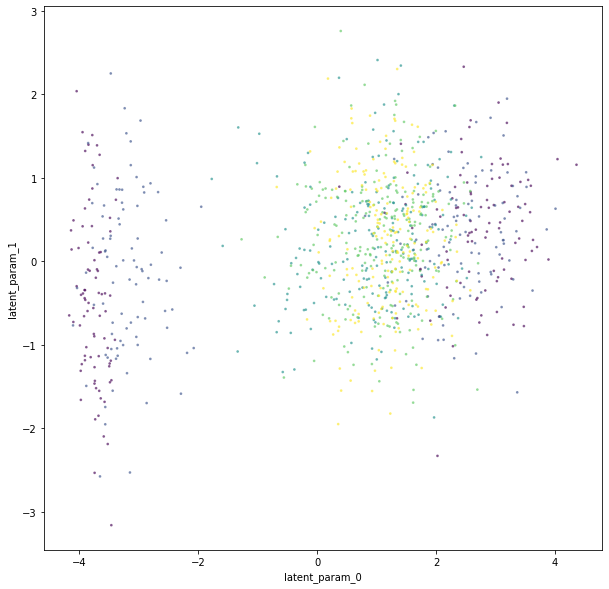

In [27]:
figsize = 10

z_points = vae.encoder.predict(x_test)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points[:, 0] , z_points[:, 1], c=test_with_meta_info['T'], alpha=0.5, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.show()

In [28]:
test_with_meta_info[test_with_meta_info['T'] < 2]

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,T,M
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
20,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
25,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
957,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
964,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
980,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0


In [29]:
test_with_meta_info[test_with_meta_info['T'] < 2].index

Int64Index([  2,   5,   7,  20,  25,  29,  31,  34,  40,  42,
            ...
            907, 927, 935, 949, 950, 954, 957, 964, 980, 989],
           dtype='int64', length=179)

In [30]:
#len(x_test)
test_with_meta_info = test_with_meta_info.reset_index()

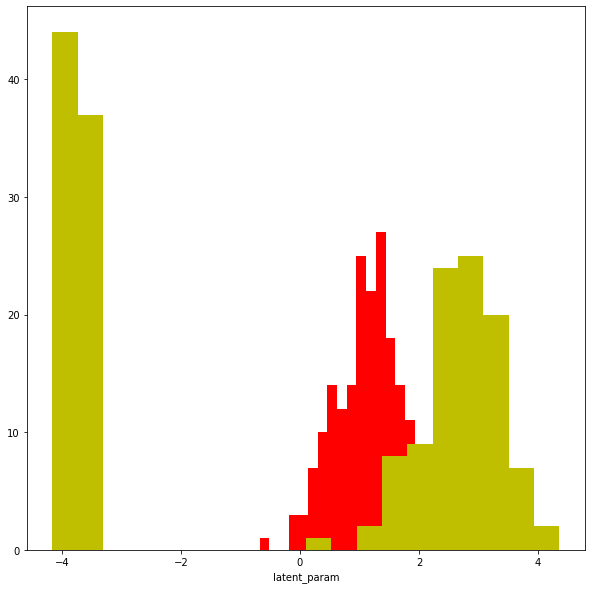

In [31]:
plt.figure(figsize=(figsize, figsize))
plt.hist(z_points[:, 0][test_with_meta_info[test_with_meta_info['T'] > 4].index], color='r', bins=20)
plt.hist(z_points[:, 0][test_with_meta_info[test_with_meta_info['T'] < 2].index], color='y', bins=20)
plt.xlabel("latent_param")
plt.savefig("{}/s3-bucket/reproduction/fig_2/vae_dense_latent_param_hist_l{}.png".format(prefix_s3, L))

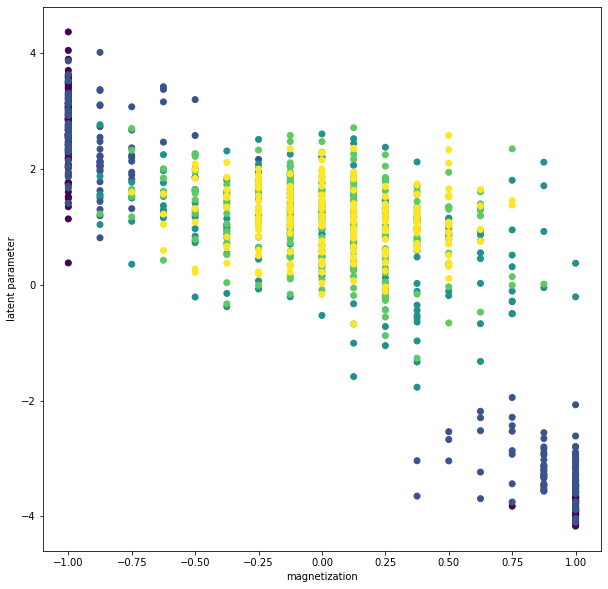

In [32]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(test_with_meta_info['M'], z_points[:,0], c=test_with_meta_info['T'])
plt.xlabel("magnetization")
plt.ylabel("latent parameter")
plt.savefig("{}/s3-bucket/reproduction/fig_2/vae_dense_scatter_latent_vs_mag_color_by_t_l{}.png".format(prefix_s3, L))

In [33]:
vae.model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 256)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 2)            514         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 2)            0           ['dense[0][0]']                  
                                                                                                  
 mu (Dense)                     (None, 2)            6           ['leaky_re_lu[0][0]']            
                                                                                            

In [34]:
mid_layer = vae.encoder.get_layer('dense')
#mid_layer = vae.decoder.get_layer('dense_3')
#mid_layer = vae.encoder.get_layer('mu')

In [35]:
mid_layer.get_weights()[0].shape

(256, 2)

In [36]:
#mid_layer.weights
#mid_layer.get_weights()

ValueError: cannot reshape array of size 2 into shape (16,16)

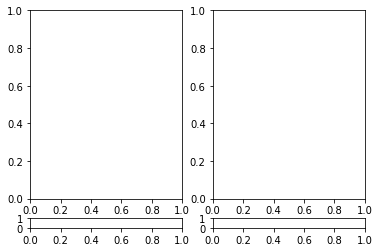

In [37]:
# There are a couple of different places to get the weights and they have different shapes
# IN the second above cell you can see different ways/places but here is a flag so you can
# create this plot depending on the choice
shape_style = 2


vmax = 0.0
vmin = 0.0
for i in range(N_DENSE):
    cur_w = mid_layer.get_weights()[0][:,-(i+1)]
    if max(cur_w) > vmax:
        vmax = max(cur_w)
    
    if min(cur_w) < vmin:
        vmin = min(cur_w)
        

fig, (axes, ax_color) = plt.subplots(2,N_DENSE, gridspec_kw={"height_ratios":[1, 0.05]})
im_list = []

if N_DENSE > 1:
    for i, ax in enumerate(axes.flat):
        if shape_style == 1:
            im = ax.imshow(mid_layer.get_weights()[0][:,-(i+1)].reshape(L,L), vmin=vmin, vmax=vmax)
        elif shape_style == 2:
            im = ax.imshow(mid_layer.get_weights()[0][i].reshape(L,L), vmin=vmin, vmax=vmax)
        else:
            raise ValueError("invalid shape style")
        im_list.append(im)
    for i, ax in enumerate(ax_color.flat):
    #for i, ax in enumerate(ax_color):
        fig.colorbar(im_list[i], cax=ax, orientation="horizontal")
else: 
    im = axes.imshow(mid_layer.get_weights()[0][:,-(i+1)].reshape(L,L), vmin=vmin, vmax=vmax)
    im_list.append(im)
    fig.colorbar(im, cax=ax_color, orientation="horizontal")

plt.savefig("{}/s3-bucket/ising/vae_dense_weights_as_image_l{}".format(prefix_s3, L))

In [ ]:
#mid_layer_2 = vae.encoder.get_layer('dense')
mid_layer_2 = vae.decoder.get_layer('dense_3')

In [ ]:
plt.imshow(mid_layer_2.get_weights()[0][0].reshape(L,L))
plt.colorbar()

# Fig. 2.c

In [ ]:
#full_latent_out = vae.encoder.predict(filterned_confs.drop(["T","M"], axis=1))
test_with_meta_info

In [ ]:
test_with_meta_info["latent_1"] = z_points[:, 0]

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [ ]:
test_with_meta_info.to_sql('filtered_confs', con=engine, if_exists='append')

In [ ]:
avg_m_out = engine.execute(
"""
    select 
        t,
        avg(abs(m)),
        avg(abs(latent_1))
    from filtered_confs
    group by t
""").fetchall()

In [ ]:
plt.plot(
    [i[0] for i in avg_m_out[0:]],
    [i[1] for i in avg_m_out[0:]],
    c='r',
    label="magnetization"
)
plt.plot(
    [i[0] for i in avg_m_out[0:]],
    [i[2] for i in avg_m_out[0:]],
    c='b',
    label="latent param."
)
plt.xlabel("Temperature")
plt.legend()
plt.savefig("{}/s3-bucket/reproduction/fig_2/vae_dense_magnitization_and_latent_param_vs_temp_l{}_r_loss_factor_{}_epocs_{}.png".format(prefix_s3, L, R_LOSS_FACTOR, EPOCHS))

# Simple AE Recreate from Latent Space

In [ ]:
recreate_sample_size = 10

plt.figure(figsize=(3, recreate_sample_size*2))

sampled_look = filterned_confs.drop(["T","M"], axis=1).sample(recreate_sample_size)
sampled_latent_out = simp_ae.predict(sampled_look)

for i in range(recreate_sample_size):
    
    plt1 = plt.subplot2grid((recreate_sample_size,2), (i,0), colspan=1)
    plt2 = plt.subplot2grid((recreate_sample_size,2), (i,1), colspan=1)
    
    plt1.imshow(
        sampled_look.iloc[i].to_numpy().reshape(L,L)
    )
    plt2.imshow(
        sampled_latent_out[i].reshape(L,L)
    )